In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from scipy.linalg import fractional_matrix_power
import itertools

from datetime import date
import time

In [2]:
import warnings

warnings.filterwarnings("ignore")

import random

seed = 2024
random.seed(seed)
np.random.seed(seed)

## Toy dataset

In [3]:
def sigma(x):
    """
    Computes the sigmoid function.

    The sigmoid function is defined as:
        σ(x) = 1 / (1 + exp(-x))

    Parameters:
    x (float or array-like): Input value or array.

    Returns:
    float or numpy.ndarray: Sigmoid function applied element-wise.
    """
    return 1 / (1 + np.exp(-x))


def ind(i, j, k):
    """
    Indicator function for block separation.

    Determines whether indices `i` and `j` belong to the same block of size `k`.

    Parameters:
    i (int): First index.
    j (int): Second index.
    k (int): Block size.

    Returns:
    int: 1 if `i` and `j` are in the same block, 0 otherwise.
    """
    return int(i // k == j // k)


def toep(d):
    """
    Constructs a Toeplitz-like correlation matrix.

    Creates a `d × d` matrix where each entry (i, j) is given by:
        (0.6) ** abs(i - j)

    Parameters:
    d (int): Dimension of the square matrix.

    Returns:
    numpy.ndarray: A `d × d` Toeplitz-like matrix.
    """
    return np.array([[(0.6) ** abs(i - j) for i in range(d)] for j in range(d)])


def ToyDataset(
    n=1000,
    d=10,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    missingness="MCAR",
    y_meth="LDA",
    beta_logist=None,
    beta_self_mask=[-1, 1],
):
    """
    Generates a dataset with controllable correlation structure, missing data patterns,
    and binary output labels.

    Parameters:
    ----------
    n : int, default=1000
        Number of samples.
    d : int, default=10
        Number of features.
    correlation : str, default="cor2"
        Correlation structure of the input data. Options:
        - "iso": Independent standard normal distribution.
        - "cor": Block correlation structure.
        - "cor2": Toeplitz correlation structure.
    eta : float, default=0.3
        Probability of missingness in MCAR (Missing Completely at Random) setting.
    k : int, default=2
        Block size for the block correlation structure.
    mu_0 : array-like or None, default=None
        Mean shift for class 0 in LDA setting. If None, defaults to a vector of ones.
    mu_1 : array-like or None, default=None
        Mean shift for class 1 in LDA setting. If None, defaults to a vector of negative ones.
    missingness : str, default="MCAR"
        Missing data mechanism. Options:
        - "MCAR": Missing Completely at Random with probability eta.
        - "MNAR": Missing Not at Random with probability 1/(1+exp(beta_self_mask[0]+beta_self_mask[1]*X^j)) for j in {1,...,d}.
    y_meth : str, default="LDA"
        Method for generating the target variable `y`. Options:
        - "LDA": Linear Discriminant Analysis style.
        - "logist": Logistic regression-based probability model.
    beta_logist : array-like or None, default=None
        Coefficients for logistic regression when `y_meth="logist"`. If None, randomly generated.
    beta_self_mask : list, default=[-1, 1]
        Coefficients for self-masking missingness mechanism in the MNAR setting.

    Returns:
    -------
    X : numpy.ndarray of shape (n, d)
        Generated feature matrix, with missing values as NaN.
    M : numpy.ndarray of shape (n, d)
        Binary mask matrix indicating missing values (1 for missing, 0 for observed).
    y : numpy.ndarray of shape (n,)
        Binary target variable.

    Notes:
    ------
    - The dataset has missing values, introduced based on the specified missingness mechanism.
    - The correlation structure affects feature dependencies.
    """
    X = np.zeros((n, d))
    M = np.zeros((n, d))

    # Input data generation
    if correlation == "iso":
        X = np.random.normal(size=(n, d))

    elif correlation == "cor":
        # Gaussian distribution with block correlation
        U = np.array([[ind(i, j, k) for j in range(d)] for i in range(d)]) / np.sqrt(k)
        X = np.random.normal(size=(n, d)) @ U + np.ones(d)

    elif correlation == "cor2":
        # Gaussian distribution with Toeplitz correlation
        X = np.random.multivariate_normal(np.zeros(d), toep(d), size=n)
    else:
        print("WARNING: Unrecognized keyword for correlation structure.")

    # Output data generation
    if y_meth == "LDA":
        # y randomly chosen with equal probability for both classes
        y = np.random.binomial(n=1, p=0.5, size=n)
        if mu_0 is None:
            mu_0 = np.ones(d)
        if mu_1 is None:
            mu_1 = -np.ones(d)
        for i in range(n):
            if y[i] == 0:
                X[i, :] += mu_0
            else:
                X[i, :] += mu_1
    elif y_meth == "logist":
        if beta_logist is None:
            beta_logist = np.random.normal(size=d)
        y = np.random.binomial(n=1, p=sigma(X @ beta_logist))

    # Missing pattern
    if missingness == "MCAR":
        M = np.random.binomial(n=1, p=eta, size=(n, d))
    elif missingness == "MNAR":
        M = np.random.binomial(n=1, p=sigma(beta_self_mask[0] + beta_self_mask[1] * X))

    X[M == 1] = np.nan  # Apply missing values

    return X, M, y


def ToyDatasetComp(
    n=1000,
    d=10,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    y_meth="LDA",
    beta_logist=None,
):
    """
    Generates a synthetic dataset with controllable correlation structure
    and binary output labels, without introducing missing values.

    Parameters:
    ----------
    n : int, default=1000
        Number of samples.
    d : int, default=10
        Number of features.
    correlation : str, default="cor2"
        Correlation structure of the input data. Options:
        - "iso": Independent standard normal distribution.
        - "cor": Block correlation structure.
        - "cor2": Toeplitz correlation structure.
    eta : float, default=0.3
        Not used in this function, but kept for consistency with ToyDataset.
    k : int, default=2
        Block size for the block correlation structure.
    mu_0 : array-like or None, default=None
        Mean shift for class 0 in LDA setting. If None, defaults to a vector of ones.
    mu_1 : array-like or None, default=None
        Mean shift for class 1 in LDA setting. If None, defaults to a vector of negative ones.
    y_meth : str, default="LDA"
        Method for generating the target variable `y`. Options:
        - "LDA": Linear Discriminant Analysis style.
        - "logist": Logistic regression-based probability model.
    beta_logist : array-like or None, default=None
        Coefficients for logistic regression when `y_meth="logist"`. If None, randomly generated.

    Returns:
    -------
    X : numpy.ndarray of shape (n, d)
        Generated feature matrix.
    y : numpy.ndarray of shape (n,)
        Binary target variable.

    Notes:
    ------
    - This function does not introduce missing values.
    - The correlation structure affects feature dependencies.
    """
    X = np.zeros((n, d))

    # Input data generation
    if correlation == "iso":
        X = np.random.normal(size=(n, d))

    elif correlation == "cor":
        # Gaussian distribution with block correlation
        U = np.array([[ind(i, j, k) for j in range(d)] for i in range(d)]) / np.sqrt(k)
        X = np.random.normal(size=(n, d)) @ U + np.ones(d)

    elif correlation == "cor2":
        # Gaussian distribution with Toeplitz correlation
        X = np.random.multivariate_normal(np.zeros(d), toep(d), size=n)
    else:
        print("WARNING: Unrecognized keyword for correlation structure.")

    # Output data generation
    if y_meth == "LDA":
        y = np.random.binomial(n=1, p=0.5, size=n)
        if mu_0 is None:
            mu_0 = np.ones(d)
        if mu_1 is None:
            mu_1 = -np.ones(d)
        for i in range(n):
            X[i, :] += mu_0 if y[i] == 0 else mu_1
    elif y_meth == "logist":
        if beta_logist is None:
            beta_logist = np.random.normal(size=d)
        y = np.random.binomial(n=1, p=sigma(X @ beta_logist))

    return X, y

In [4]:
X, M, y = ToyDataset(
    n=1000,
    d=10,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    missingness="MCAR",
    y_meth="LDA",
)

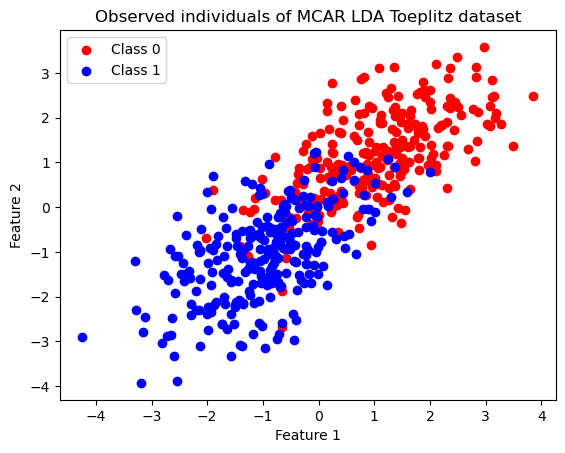

In [5]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", label="Class 1")

plt.title("Observed individuals of MCAR LDA Toeplitz dataset")  # Add title
plt.legend()  # Show legend
plt.xlabel("Feature 1")  # Label for x-axis (optional)
plt.ylabel("Feature 2")  # Label for y-axis (optional)
plt.show()

In [6]:
n = 1000
d = 10
X, M, y = ToyDataset(
    n=n,
    d=d,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    missingness="MNAR",
    y_meth="LDA",
    beta_self_mask=[-1.1, 1],
)

Proportion of missing values: 0.3228


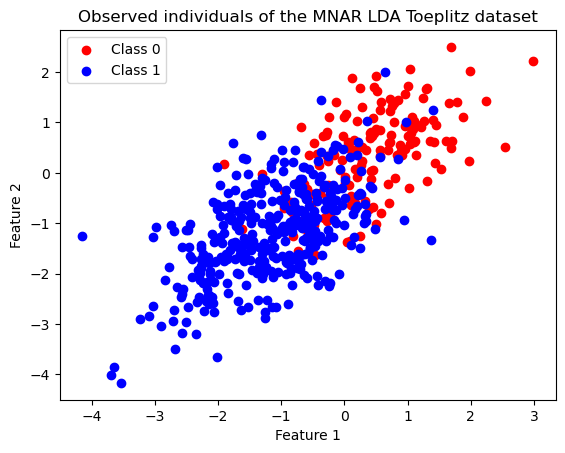

In [7]:
print("Proportion of missing values: " + str(np.sum(M == 1) / (n * d)))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", label="Class 1")
plt.title("Observed individuals of the MNAR LDA Toeplitz dataset")  # Add title
plt.legend()  # Show legend
plt.xlabel("Feature 1")  # Label for x-axis (optional)
plt.ylabel("Feature 2")  # Label for y-axis (optional)
plt.show()

In [8]:
n = 1000
d = 10
X, M, y = ToyDataset(
    n=n,
    d=d,
    correlation="cor2",
    eta=0.3,
    k=2,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1, 1],
)

Proportion of missing values: 0.2993


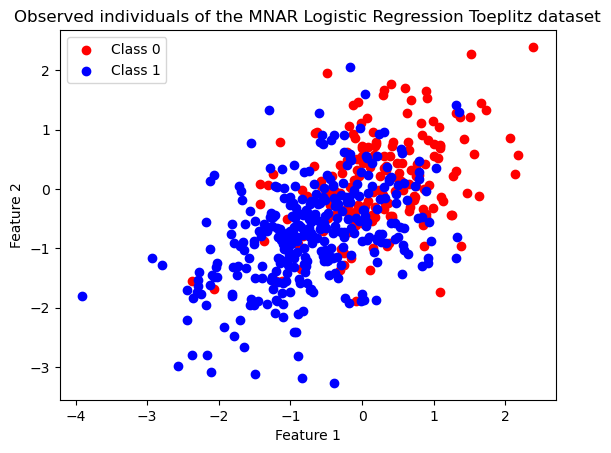

In [9]:
print("Proportion of missing values: " + str(np.sum(M == 1) / (n * d)))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", label="Class 1")
plt.title(
    "Observed individuals of the MNAR Logistic Regression Toeplitz dataset"
)  # Add title
plt.legend()  # Show legend
plt.xlabel("Feature 1")  # Label for x-axis (optional)
plt.ylabel("Feature 2")  # Label for y-axis (optional)
plt.show()

## Linear classifiers with missing values

In this section, we implement linear methods (Logistic Regression, Perceptron, and Linear Discriminant Analysis) adapted to handle missing values through the following approaches:

1. **0-imputation**: Imputing all missing values with 0.
2. **Pattern-by-pattern approach**: Implementing a regressor for each missing pattern.
3. **Iterative imputer**: Imputing all missing values using *IterativeImputer* from *sklearn*.

For LDA, **LDA-MCAR** accounts for the MCAR (Missing Completely at Random) mechanism to compute the expectation across all observed values.


### General class

In [10]:
class Classification:
    """
    Base class for classification models.

    This class provides a structure for classification models with a common method
    for evaluating test error. Subclasses should implement the `predict` method.

    Attributes:
    ----------
    name : str, default=""
        Name of the classifier, used for plotting or identification.

    Methods:
    -------
    test_error(X, M, y):
        Computes the classification error as the mean absolute difference
        between predictions and true labels.

    predict(X, M):
        Must be implemented in subclasses to return predicted labels.
    """

    def __init__(self, name=""):
        """
        Initializes the classification model.

        Parameters:
        ----------
        name : str, default=""
            Name of the classifier.
        """
        self.name = name  # Name will be used for plotting or identification

    def test_error(self, X, M, y):
        """
        Computes the classification error.

        The error is measured as the mean absolute difference between predicted
        and actual labels. The assumption is that labels are binary (0 or 1).

        Parameters:
        ----------
        X : numpy.ndarray
            Feature matrix of shape (n_samples, n_features).
        M : numpy.ndarray
            Missing data mask of the same shape as X, where 1 indicates missing values.
        y : numpy.ndarray
            True binary labels of shape (n_samples,).

        Returns:
        -------
        float
            The mean classification error.
        """
        return np.mean(
            np.abs(self.predict(X, M) - y)
        )  # Classes are assumed to be 0 or 1

    def predict(self, X, M):
        """
        Placeholder method for making predictions.

        This method should be implemented in subclasses to provide actual predictions.

        Parameters:
        ----------
        X : numpy.ndarray
            Feature matrix.
        M : numpy.ndarray
            Missing data mask.

        Returns:
        -------
        numpy.ndarray
            Predicted labels.

        Raises:
        ------
        NotImplementedError
            If the method is not overridden in a subclass.
        """
        raise NotImplementedError("Subclasses must implement the predict method.")

### Logistic Regression

Imputed by 0 Logistic Regression

In [11]:
class LogisticRegression0Imputation(Classification):
    """
    Logistic Regression model with imputation for missing values.

    This class extends the Classification base class and implements a logistic
    regression model where missing values are imputed with zero before fitting.
    The missing data mask (M) is also included as a covariate in the model.

    Methods:
    -------
    fit(X, M, y):
        Fits the logistic regression model, imputing missing values with zero
        and adding the missing data mask as a covariate.

    predict(X, M):
        Makes predictions using the fitted model, imputing missing values with zero
        and including the missing data mask as a covariate.
    """

    def fit(self, X, M, y):
        """
        Fits the logistic regression model with zero imputation for missing data.

        The missing data in `X` is imputed with zeros, and the missingness mask `M`
        is added as an additional feature for the logistic regression model.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.
        y : numpy.ndarray of shape (n_samples,)
            True binary labels (0 or 1).

        Returns:
        -------
        None
            The method modifies the instance by fitting the logistic regression model.
        """
        Xp = X.copy()
        Xp[M == 1] = 0  # Impute missing values with 0
        self.reg = LogisticRegression(penalty=None).fit(
            np.hstack((Xp, M)), y
        )  # Add M as a covariate to the feature set

    def predict(self, X, M):
        """
        Makes predictions using the fitted logistic regression model.

        The method imputes missing values in `X` with zeros and includes the missingness
        mask `M` as an additional feature when making predictions.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.

        Returns:
        -------
        numpy.ndarray of shape (n_samples,)
            Predicted binary labels (0 or 1).
        """
        Xp = X.copy()
        Xp[M == 1] = 0  # Impute missing values with 0
        return self.reg.predict(np.hstack((Xp, M)))  # Use M as an additional feature

In [12]:
# We test the method with logistic data:
X, M, y = ToyDataset(
    n=1000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = LogisticRegression0Imputation(name="RL-OImput")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.40444444444444444

Pattern-by-pattern Logistic Regression

In [13]:
class LogisticRegressionPbP(Classification):
    """
    Logistic Regression model with a pattern-by-pattern strategy for missing data.

    This class extends the `Classification` base class and implements a logistic regression
    model where missing values are handled using a pattern-by-pattern approach.
    A separate logistic regression model is trained for each unique missing data pattern in the training set.

    Methods:
    -------
    fit(X, M, y):
        Fits a logistic regression model for each unique missing data pattern in the training set.

    pred(X, m):
        Makes a prediction for a given input `X` based on its missing data pattern `m`.

    predict(X, M):
        Makes predictions for all instances in the dataset `X` based on their respective missing data patterns `M`.
    """

    def fit(self, X, M, y):
        """
        Fits logistic regression models for each unique missing data pattern.

        For each unique pattern of missing data in `M`, a logistic regression model is trained
        using the subset of the data where the missingness pattern is the same.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.
        y : numpy.ndarray of shape (n_samples,)
            True binary labels (0 or 1).

        Returns:
        -------
        None
            The method modifies the instance by training logistic regression models for each missing pattern.
        """
        self.X = X.copy()
        self.M = M
        self.y = y
        self.dic = (
            {}
        )  # Dictionary to store logistic regression models for each missing pattern

        # Loop over each unique missing data pattern
        for i in range(len(M)):
            indices_0 = np.array(self.y == 0) & np.all(M == M[i], axis=1)
            indices_1 = np.array(self.y == 1) & np.all(M == M[i], axis=1)

            # Only proceed if this missing pattern hasn't been seen before, and conditions hold
            if (
                not (
                    str(M[i]) in self.dic
                )  # Check if this missing pattern is already in the dictionary
                and np.product(M[i]) == 0  # Ensure the pattern isn't all missing values
                and sum(indices_0)
                > 0  # Ensure there are class 0 samples for this pattern
                and sum(indices_1)
                > 0  # Ensure there are class 1 samples for this pattern
            ):
                n = len(self.X)
                S = np.asarray(
                    [np.product(M[j] == M[i]) for j in range(n)]
                )  # Identify samples with the same missing pattern
                Xp = self.X[S == 1][
                    :, M[i] == 0
                ]  # Impute missing values in Xp where the missingness pattern matches M[i]
                yp = self.y[S == 1]  # Labels corresponding to the selected samples
                reg = LogisticRegression(n_jobs=-1, penalty=None).fit(
                    np.array(Xp, ndmin=2), yp
                )  # Train logistic regression model on the valid samples
                self.dic[str(self.M[i])] = (
                    reg  # Store the model for this missing pattern in the dictionary
                )

    def pred(self, X, m):
        """
        Makes a prediction for a given instance based on its missing data pattern.

        If the missing data pattern `m` has been seen during training,
        the corresponding logistic regression model is used to make a prediction.
        If the pattern was not seen during training, a random prediction with equal probability is returned.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_features,)
            Feature vector for the instance to be predicted.
        m : numpy.ndarray of shape (n_features,)
            Missing data pattern for the instance (0 for observed, 1 for missing).

        Returns:
        -------
        int
            Predicted binary label (0 or 1).
        """
        m = np.asarray(m)
        if not (str(m) in self.dic) or np.product(m) == 1:
            return np.random.binomial(
                n=1, p=0.5
            )  # If the missingness pattern is unknown or all values are missing, make a random prediction
        else:
            reg = self.dic[
                str(m)
            ]  # Retrieve the model for the current missingness pattern
            return reg.predict(np.array(X[m == 0], ndmin=2))[
                0
            ]  # Make a prediction for observed features only

    def predict(self, X, M):
        """
        Makes predictions for all instances in the dataset `X` based on their missing data patterns.

        For each instance, the method calls `pred` to get a prediction based on its corresponding missingness pattern from `M`.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.

        Returns:
        -------
        numpy.ndarray of shape (n_samples,)
            Array of predicted binary labels (0 or 1) for each instance.
        """
        n = len(X)
        prediction = np.array(
            [self.pred(X[i], M[i]) for i in range(n)], ndmin=2
        )  # Predict for all instances based on their missing patterns
        return prediction

In [14]:
# We test the method with logistic data:
X, M, y = ToyDataset(
    n=1000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = LogisticRegressionPbP(name="RL-p-b-p")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.2677777777777778

Iterative imputer Logistic Regression

In [15]:
class LogisticRegressionIterativeImputation(Classification):
    """
    Logistic Regression model with Iterative Imputation strategy for missing data.

    This class extends the `Classification` base class and implements a logistic regression
    model with iterative imputation for missing values. Iterative imputation is used to
    estimate missing values based on the other available values in the dataset.
    A logistic regression model is then trained using the imputed data and the missingness mask.

    Methods:
    -------
    fit(X, M, y):
        Fits the logistic regression model after imputing missing values using iterative imputation.

    predict(X, M):
        Predicts the labels for the input data after imputing missing values.
    """

    def fit(self, X, M, y):
        """
        Fits the logistic regression model with iterative imputation for missing data.

        This method applies iterative imputation to fill in the missing values in the feature matrix `X`,
        then trains a logistic regression model using the imputed dataset and the missingness mask `M`.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.
        y : numpy.ndarray of shape (n_samples,)
            True binary labels (0 or 1).

        Returns:
        -------
        None
            The method modifies the instance by fitting the logistic regression model after imputation.
        """
        Xp = X.copy()  # Copy of the feature matrix to preserve the original data
        self.imp_mean = IterativeImputer(
            random_state=0
        )  # Initialize the imputer for iterative imputation
        self.imp_mean.fit(
            Xp
        )  # Fit the imputer to the data (learn the missing value distribution)
        Xp = self.imp_mean.transform(
            Xp
        )  # Impute missing values in Xp using the learned distribution

        # Fit logistic regression using the imputed data along with the missingness mask as an additional covariate
        self.reg = LogisticRegression(penalty=None).fit(np.hstack((Xp, M)), y)

    def predict(self, X, M):
        """
        Predicts the labels for the input data after imputing missing values.

        This method applies the same iterative imputation strategy to the input data `X`
        to fill in missing values and then makes predictions using the previously trained
        logistic regression model.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.

        Returns:
        -------
        numpy.ndarray of shape (n_samples,)
            Predicted binary labels (0 or 1) for each instance in the dataset.
        """
        Xp = X.copy()  # Copy the feature matrix to preserve original data
        Xp = self.imp_mean.transform(
            Xp
        )  # Impute missing values in Xp using the trained imputer

        # Use the logistic regression model to make predictions based on the imputed data and missingness mask
        return self.reg.predict(np.hstack((Xp, M)))

In [16]:
# We test the method with logistic data:
X, M, y = ToyDataset(
    n=1000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = LogisticRegressionIterativeImputation(name="RL-ICE")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.2877777777777778

## Perceptron

Imputed by 0 Perceptron

In [17]:
class Perceptron0Imputation(Classification):
    """
    Perceptron model with imputation of missing data using 0 for missing values.

    This class extends the `Classification` base class and implements a Perceptron
    model where missing values are imputed using 0, and the missingness pattern (mask) is
    included as an additional covariate during model fitting. The model then predicts the
    binary class labels based on the imputed data.

    Methods:
    -------
    fit(X, M, y):
        Fits a Perceptron model after imputing missing values with 0 and using the missingness mask as a covariate.

    predict(X, M):
        Predicts the labels for the input data after imputing missing values with 0.
    """

    def fit(self, X, M, y):
        """
        Fits the Perceptron model with imputation of missing values using 0.

        In this method, missing values in the input feature matrix `X` are imputed by replacing
        them with 0. Then, the Perceptron model is trained using the imputed dataset along with the
        missingness mask `M` as an additional covariate.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.
        y : numpy.ndarray of shape (n_samples,)
            True binary labels (0 or 1).

        Returns:
        -------
        None
            The method modifies the instance by fitting the Perceptron model after imputation.
        """
        Xp = X.copy()  # Copy of the feature matrix to preserve the original data
        Xp[M == 1] = 0  # Impute missing values by replacing them with 0
        self.reg = Perceptron().fit(
            np.hstack((Xp, M)), y
        )  # Fit Perceptron using imputed data and missingness mask as a covariate

    def predict(self, X, M):
        """
        Predicts the labels for the input data after imputing missing values with 0.

        This method imputes missing values in the feature matrix `X` by replacing them with 0,
        then uses the trained Perceptron model to make predictions based on the imputed data
        and the missingness mask `M`.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.

        Returns:
        -------
        numpy.ndarray of shape (n_samples,)
            Predicted binary labels (0 or 1) for each instance in the dataset.
        """
        Xp = X.copy()  # Copy the feature matrix to preserve original data
        Xp[M == 1] = 0  # Impute missing values by replacing them with 0
        return self.reg.predict(
            np.hstack((Xp, M))
        )  # Use the Perceptron model to make predictions

In [18]:
X, M, y = ToyDataset(
    n=1000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = Perceptron0Imputation(name="Percep-OImput")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.46555555555555556

Pattern-by-pattern Perceptron

In [19]:
class PerceptronPbP(Classification):
    """
    Perceptron model with pattern-by-pattern prediction for missing data.

    This class extends the `Classification` base class and implements a Perceptron model
    that handles missing data by utilizing the missingness pattern (PbP - Pattern by Pattern).
    The model learns a separate Perceptron classifier for each unique missingness pattern
    and makes predictions based on the learned models corresponding to each pattern.

    Methods:
    -------
    fit(X, M, y):
        Fits a separate Perceptron model for each unique missingness pattern in the data.

    pred(X, m):
        Makes a prediction for a single instance using the appropriate Perceptron model
        corresponding to the missingness pattern.

    predict(X, M):
        Makes predictions for all instances in the dataset, using the appropriate Perceptron model
        for each instance's missingness pattern.
    """

    def fit(self, X, M, y):
        """
        Fits a separate Perceptron model for each unique missingness pattern.

        In this method, a separate Perceptron model is trained for each missingness pattern
        (given by `M`). The model is trained only if there are sufficient samples with the
        same missingness pattern, and the pattern has both positive and negative examples.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.
        y : numpy.ndarray of shape (n_samples,)
            True binary labels (0 or 1).

        Returns:
        -------
        None
            The method modifies the instance by fitting multiple Perceptron models based on the missingness patterns.
        """
        self.X = X.copy()  # Copy the feature matrix to preserve the original data
        self.M = M  # Missingness matrix (indicating missing values)
        self.y = y  # True labels
        self.dic = {}  # Dictionary to store models for each missingness pattern

        for i in range(len(M)):
            # Indices for class 0 and class 1 where the missingness pattern matches M[i]
            indices_0 = np.array(self.y == 0) & np.all(M == M[i], axis=1)
            indices_1 = np.array(self.y == 1) & np.all(M == M[i], axis=1)

            # Train a model if:
            # 1. The pattern M[i] has not been encountered before.
            # 2. The pattern is not all missing (no NaN values).
            # 3. There are enough samples with class 0 and class 1 for that pattern.
            if (
                str(M[i]) not in self.dic  # Pattern not yet seen
                and np.product(M[i]) == 0  # Ensure pattern is not all missing
                and sum(indices_0) > 0  # Ensure class 0 samples are available
                and sum(indices_1) > 0  # Ensure class 1 samples are available
            ):
                n = len(self.X)
                S = np.asarray(
                    [np.product(M[j] == M[i]) for j in range(n)]
                )  # Select samples with similar missingness patterns
                Xp = self.X[S == 1][
                    :, M[i] == 0
                ]  # Use only the non-missing features for training
                yp = self.y[S == 1]  # Corresponding labels for those samples

                # Fit a Perceptron model to the subset of data with the current missingness pattern
                reg = Perceptron(n_jobs=-1).fit(np.array(Xp, ndmin=2), yp)

                # Store the trained model in the dictionary with the pattern as key
                self.dic[str(self.M[i])] = reg

    def pred(self, X, m):
        """
        Makes a prediction for a single instance using the appropriate Perceptron model for its missingness pattern.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_features,)
            Feature vector for a single instance with missing values.
        m : numpy.ndarray of shape (n_features,)
            Missingness mask for the instance, indicating which features are missing (1 indicates missing).

        Returns:
        -------
        int
            Predicted binary label (0 or 1) for the instance.
        """
        m = np.asarray(m)  # Ensure missingness pattern is in numpy array format
        if str(m) not in self.dic or np.product(m) == 1:
            # If no model exists for this missingness pattern, return a random prediction
            return np.random.binomial(n=1, p=0.5)
        else:
            # Use the Perceptron model for the current missingness pattern to predict the label
            reg = self.dic[str(m)]
            return reg.predict(np.array(X[m == 0], ndmin=2))[0]

    def predict(self, X, M):
        """
        Makes predictions for all instances in the dataset using the appropriate Perceptron model
        for each instance's missingness pattern.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            Feature matrix with missing values.
        M : numpy.ndarray of shape (n_samples, n_features)
            Missing data mask, where 1 indicates missing values.

        Returns:
        -------
        numpy.ndarray of shape (n_samples,)
            Predicted binary labels (0 or 1) for each instance in the dataset.
        """
        n = len(X)
        # Iterate over all samples and apply the prediction for each instance's missingness pattern
        prediction = np.array([self.pred(X[i], M[i]) for i in range(n)], ndmin=2)
        return prediction

In [20]:
X, M, y = ToyDataset(
    n=1000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = PerceptronPbP(name="Percep-p-b-p")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.44555555555555554

Iterative Imputer Perceptron

In [21]:
class PerceptronIterativeImputation(Classification):
    def fit(self, X, M, y):
        Xp = X.copy()
        self.imp_mean = IterativeImputer(random_state=0)
        self.imp_mean.fit(Xp)
        Xp = self.imp_mean.transform(Xp)
        self.reg = Perceptron().fit(np.hstack((Xp, M)), y)  # we had M to covariate

    def predict(self, X, M):
        Xp = X.copy()
        Xp = self.imp_mean.transform(Xp)
        return self.reg.predict(np.hstack((Xp, M)))

In [22]:
X, M, y = ToyDataset(
    n=1000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = PerceptronIterativeImputation(name="Percep-ICE")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.36777777777777776

### Linear discriminant analysis (LDA)

Function to estimate the covariance matrix:

In [23]:
def cov_estim(X, M, y):
    mu_0 = np.nanmean(X[y == 0], axis=0)
    mu_1 = np.nanmean(X[y == 1], axis=0)
    sigma_0 = np.zeros((X.shape[1], X.shape[1]))
    sigma_1 = np.zeros((X.shape[1], X.shape[1]))
    for k in range(X.shape[1]):
        for l in range(k + 1):
            ind_0 = (y == 0) & (M[:, k] == 0) & (M[:, l] == 0)
            sigma_0[k, l] = np.mean((X[ind_0, k] - mu_0[k]) * (X[ind_0, l] - mu_0[l]))
            sigma_0[l, k] = sigma_0[k, l]
            ind_1 = (y == 1) & (M[:, k] == 0) & (M[:, l] == 0)
            sigma_1[k, l] = np.mean((X[ind_1, k] - mu_1[k]) * (X[ind_1, l] - mu_1[l]))
            sigma_1[l, k] = sigma_1[k, l]
    pi_0 = np.sum(y == 0) / y.shape
    pi_1 = np.sum(y == 1) / y.shape
    return pi_0 * sigma_0 + pi_1 * sigma_1

In [24]:
X, M, y = ToyDataset(
    n=1000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]
cov_estim(X_train, M_train, y_train)

array([[0.79338311, 0.44236525],
       [0.44236525, 0.55710645]])

Imputed by 0 LDA

In [25]:
class LDA0Imputation(Classification):
    """
    Linear Discriminant Analysis (LDA) with 0 imputation for missing values.

    This class implements Linear Discriminant Analysis (LDA) for classification tasks,
    where missing values in the input data are imputed by setting them to zero.
    The model estimates class means, covariance matrix, and class proportions, and
    performs predictions based on the LDA decision rule.

    Parameters:
    ----------
    None
    """

    def fit(self, X, M, y):
        """
        Fits the LDA model to the provided data, imputing missing values with zeros.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The feature matrix with potential missing values (NaNs). Each row corresponds
            to a sample and each column to a feature.

        M : numpy.ndarray of shape (n_samples, n_features)
            A missingness mask where M[i, j] == 1 if the value at X[i, j] is missing
            and M[i, j] == 0 if the value at X[i, j] is observed.

        y : numpy.ndarray of shape (n_samples,)
            The target binary labels (0 or 1) corresponding to the classes for each sample.
        """
        Xp = X.copy()  # Copy the feature matrix to avoid modifying original data
        Xp[M == 1] = 0  # Set missing values to 0 (imputation)

        # Compute class-specific means (mu_0, mu_1)
        self.mu_0 = np.mean(Xp[y == 0], axis=0)
        self.mu_1 = np.mean(Xp[y == 1], axis=0)

        # Estimate the covariance matrix using the observed values
        self.sigma = cov_estim(X, M, y)

        # Calculate class proportions
        self.pi_0 = np.sum(y == 0) / y.shape[0]
        self.pi_1 = np.sum(y == 1) / y.shape[0]

    def predict(self, X, M):
        """
        Predicts the class labels for the input data using the LDA decision rule.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The feature matrix with potential missing values (NaNs). Each row corresponds
            to a sample and each column to a feature.

        M : numpy.ndarray of shape (n_samples, n_features)
            A missingness mask where M[i, j] == 1 if the value at X[i, j] is missing
            and M[i, j] == 0 if the value at X[i, j] is observed.

        Returns:
        -------
        numpy.ndarray of shape (n_samples,)
            The predicted class labels (0 or 1) for each sample.
        """
        Xp = X.copy()  # Copy the feature matrix to avoid modifying original data
        Xp[M == 1] = 0  # Set missing values to 0 (imputation)

        # Compute the LDA decision rule:
        # (X - (mu_1 + mu_0) / 2) * inv(sigma) * (mu_1 - mu_0) - log(pi_0 / pi_1)
        decision = np.dot(
            Xp - (self.mu_1 + self.mu_0) / 2,
            np.dot(
                (self.mu_1 - self.mu_0),
                np.linalg.inv(self.sigma + 0.001 * np.eye(X.shape[1])),
            ),
        ) - np.log(self.pi_0 / self.pi_1)

        # Return class label 1 if the decision value is >= 0, else class label 0
        return (decision >= 0).astype(int)

In [26]:
X, M, y = ToyDataset(
    n=1000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = LDA0Imputation(name="LDA-OImput")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.3788888888888889

Iterative imputer LDA

In [27]:
class LDAIterativeImputation(Classification):
    """
    Linear Discriminant Analysis (LDA) with Iterative Imputation for missing values.

    This class implements LDA for classification tasks, where missing values in the input
    data are handled using Iterative Imputation (using IterativeImputer from sklearn).
    The class estimates class means, covariance matrix, and class proportions, and performs
    predictions using the LDA decision rule.

    Parameters:
    ----------
    None
    """

    def fit(self, X, M, y):
        """
        Fits the LDA model to the provided data, imputing missing values iteratively.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The feature matrix with potential missing values (NaNs). Each row corresponds
            to a sample and each column to a feature.

        M : numpy.ndarray of shape (n_samples, n_features)
            A missingness mask where M[i, j] == 1 if the value at X[i, j] is missing
            and M[i, j] == 0 if the value at X[i, j] is observed.

        y : numpy.ndarray of shape (n_samples,)
            The target binary labels (0 or 1) corresponding to the classes for each sample.
        """
        Xp = X.copy()

        # Handling columns with all missing values by setting them to zero
        cols_all_null = np.all(np.isnan(Xp), axis=0)
        Xp[:, cols_all_null] = 0

        # Iterative Imputation
        self.imp_mean = IterativeImputer(random_state=seed)
        self.imp_mean.fit(Xp)
        Xp = self.imp_mean.transform(Xp)

        # Compute class-specific means (mu_0, mu_1)
        self.mu_0 = np.mean(Xp[y == 0], axis=0)
        self.mu_1 = np.mean(Xp[y == 1], axis=0)

        # Estimate covariance matrix using the provided cov_estim function
        self.sigma = cov_estim(X, M, y)

        # Calculate class proportions
        self.pi_0 = np.sum(y == 0) / y.shape[0]  # Corrected to y.shape[0]
        self.pi_1 = np.sum(y == 1) / y.shape[0]  # Corrected to y.shape[0]

    def predict(self, X, M):
        """
        Predicts the class labels for the input data using the LDA decision rule.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The feature matrix with potential missing values (NaNs). Each row corresponds
            to a sample and each column to a feature.

        M : numpy.ndarray of shape (n_samples, n_features)
            A missingness mask where M[i, j] == 1 if the value at X[i, j] is missing
            and M[i, j] == 0 if the value at X[i, j] is observed.

        Returns:
        -------
        numpy.ndarray of shape (n_samples,)
            The predicted class labels (0 or 1) for each sample.
        """
        Xp = X.copy()  # Copy the feature matrix to avoid modifying original data
        Xp = self.imp_mean.transform(Xp)  # Apply iterative imputation

        # Compute the LDA decision rule:
        decision = np.dot(
            Xp - (self.mu_1 + self.mu_0) / 2,
            np.dot(
                (self.mu_1 - self.mu_0),
                np.linalg.inv(self.sigma + 0.001 * np.eye(self.sigma.shape[0])),
            ),
        ) - np.log(self.pi_0 / self.pi_1)

        # Return class label 1 if the decision value is >= 0, else class label 0
        return (decision >= 0).astype(int)

In [28]:
X, M, y = ToyDataset(
    n=200,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    missingness="MCAR",
    y_meth="LDA",
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = LDAIterativeImputation(name="LDA-ICEImput")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.22

LDA with MCAR data

In [29]:
class LDA_MCAR(Classification):
    def fit(self, X, M, y):
        """
        Fit the LDA model with the given data, considering missingness patterns (MCAR).

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The feature matrix (n_samples x n_features) with missing values.

        M : numpy.ndarray of shape (n_samples, n_features)
            The missingness matrix (n_samples x n_features), where M[i, j] == 1 if X[i, j] is missing.

        y : numpy.ndarray of shape (n_samples,)
            The class labels (binary labels: 0 or 1).
        """
        Xp = X.copy()

        # Estimate covariance using the cov_estim function
        self.sigma = cov_estim(X, M, y)

        # Compute class means for the two classes (0 and 1), ignoring missing values
        self.mu_0 = np.nanmean(Xp[y == 0], axis=0)
        self.mu_1 = np.nanmean(Xp[y == 1], axis=0)

        # Calculate class proportions (corrected to y.shape[0])
        self.pi_0 = np.sum(y == 0) / y.shape[0]  # Corrected to y.shape[0]
        self.pi_1 = np.sum(y == 1) / y.shape[0]  # Corrected to y.shape[0]

        # Store inverse covariance for each missingness pattern
        self.dic_cov = {}
        for i in range(len(M)):
            if not (str(M[i]) in self.dic_cov) and (sum(M[i] == 0) > 1):
                self.dic_cov[str(M[i])] = np.linalg.inv(
                    self.sigma[np.ix_(M[i] == 0, M[i] == 0)]
                    + 0.001 * np.eye(sum(M[i] == 0))
                )

    def pred(self, X, m):
        """
        Predict the class label for a single sample with a given missingness pattern.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_features,)
            The feature vector for a single sample.

        m : numpy.ndarray of shape (n_features,)
            The missingness pattern for the sample (1 for missing, 0 for observed).

        Returns:
        -------
        int : Predicted class label (0 or 1).
        """
        m = np.asarray(m)

        # Handle the case where all features are missing
        if np.product(m) == 1:
            return np.random.binomial(n=1, p=0.5)

        # If the missingness pattern is not found in the dictionary, calculate covariance inverse
        if not (str(m) in self.dic_cov):
            if np.sum(m == 0) == 1:  # Only one observed feature
                return int(
                    (self.mu_1[m == 0] - self.mu_0[m == 0])
                    * 1
                    / self.sigma[m == 0, m == 0]
                    * (X[m == 0] - (self.mu_1[m == 0] + self.mu_0[m == 0]) / 2)
                    - np.log(self.pi_0 / self.pi_1)
                    >= 0
                )
            else:
                self.dic_cov[str(m)] = np.linalg.inv(
                    self.sigma[np.ix_(m == 0, m == 0)] + 0.001 * np.eye(sum(m == 0))
                )

        # Compute the decision rule for the given missingness pattern
        return int(
            np.dot(
                np.dot((self.mu_1[m == 0] - self.mu_0[m == 0]), self.dic_cov[str(m)]),
                X[m == 0] - (self.mu_1[m == 0] + self.mu_0[m == 0]) / 2,
            )
            - np.log(self.pi_0 / self.pi_1)
            >= 0
        )

    def predict(self, X, M):
        """
        Predict class labels for the entire dataset using the learned model.

        Parameters:
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The feature matrix (n_samples x n_features) for all samples.

        M : numpy.ndarray of shape (n_samples, n_features)
            The missingness matrix (n_samples x n_features) indicating missing values.

        Returns:
        -------
        numpy.ndarray : Predicted class labels (binary labels: 0 or 1) for all samples.
        """
        n = len(X)
        prediction = np.array([self.pred(X[i], M[i]) for i in range(n)], ndmin=2)
        return prediction

In [30]:
X, M, y = ToyDataset(
    n=10000,
    d=2,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    missingness="MCAR",
    y_meth="LDA",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:10000], M[:10000], y[:10000]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = LDA_MCAR(name="LDA-MCAR")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.1785858585858586

LDA pattern-by-pattern

In [31]:
class LDAPbP(Classification):
    """
    Linear Discriminant Analysis (LDA) decomposed pattern-by-pattern to handle with missing data.

    This model is designed to handle missing data by considering a model per missingness pattern.
    The model estimates class-specific parameters (means, covariances, priors) for each unique missingness pattern in
    the data and uses these to make predictions. This is a variation of LDA that takes into account the missing data
    structure by making predictions based on available features and learned parameters for different patterns of missingness.

    Attributes:
        dic_cov (dict): A dictionary storing the inverse of the covariance matrices for each missingness pattern.
        dic_mu_0 (dict): A dictionary storing the mean vectors for class 0 for each missingness pattern.
        dic_mu_1 (dict): A dictionary storing the mean vectors for class 1 for each missingness pattern.
        dic_pi_0 (dict): A dictionary storing the class proportion for class 0 for each missingness pattern.
        dic_pi_1 (dict): A dictionary storing the class proportion for class 1 for each missingness pattern.

    Methods:
        fit(X, M, y):
            Fits the LDA model to the data, estimating the model parameters (means, covariances, priors) for each
            unique missingness pattern.

        pred(X, m):
            Makes a prediction for a single sample `X` with missingness pattern `m`.
            It uses the precomputed class means, priors, and covariance matrix for the given missingness pattern
            to calculate the posterior probabilities and return the predicted class label.

        predict(X, M):
            Predicts the class labels for all samples in `X` given the corresponding missingness patterns `M`.
    """

    def fit(self, X, M, y):
        """
        Fits the model to the training data by estimating the class-specific parameters
        (means, covariances, and priors) for each unique missingness pattern.

        Args:
            X (ndarray): The feature matrix (n_samples x n_features) where some values may be missing (NaN).
            M (ndarray): The missingness matrix (n_samples x n_features), where 1 indicates missing data, and 0 indicates observed data.
            y (ndarray): The target vector (n_samples,) where each entry is either 0 or 1 indicating the class label.

        The method computes the means, covariances, and class priors for each unique missingness pattern found
        in the data, and stores them in dictionaries for later use in making predictions.
        """

        Xp = X.copy()
        self.dic_cov = {}
        self.dic_mu_0 = {}
        self.dic_mu_1 = {}
        self.dic_pi_0 = {}
        self.dic_pi_1 = {}

        for i in range(len(M)):
            if (
                not (str(M[i]) in self.dic_mu_0)
                and np.product(M[i]) == 0
                and (sum(M[i] == 0) >= 1)
                and sum(np.all(M == M[i], axis=1)) >= 20
            ):
                indices_0 = np.array(y == 0) & np.all(M == M[i], axis=1)
                indices_1 = np.array(y == 1) & np.all(M == M[i], axis=1)
                Xp2 = Xp[:, M[i] == 0]

                # Compute class means for the given missingness pattern
                self.dic_mu_0[str(M[i])] = np.mean(Xp2[indices_0], axis=0)
                self.dic_mu_1[str(M[i])] = np.mean(Xp2[indices_1], axis=0)

                # Compute class priors for the given missingness pattern
                self.dic_pi_0[str(M[i])] = np.sum(indices_0) / (
                    np.sum(indices_0) + np.sum(indices_1)
                )
                self.dic_pi_1[str(M[i])] = 1 - self.dic_pi_0[str(M[i])]

                # Covariance matrix estimation
                columns_to_keep = np.where(M[i] == 0)[0]
                X_M = X[:, columns_to_keep]
                cov_0 = np.cov(X_M[indices_0], rowvar=False)
                cov_1 = np.cov(X_M[indices_1], rowvar=False)
                cov = (
                    cov_0 * self.dic_pi_0[str(M[i])] + self.dic_pi_1[str(M[i])] * cov_1
                )
                cov = cov + np.eye(sum(1 - M[i])) * 0.001  # Regularization term
                self.dic_cov[str(M[i])] = np.linalg.inv(cov)

    def pred(self, X, m):
        """
        Makes a prediction for a single sample based on the available features and the missingness pattern.

        Args:
            X (ndarray): The feature vector (n_features,) for the sample to predict.
            m (ndarray): The missingness pattern (n_features,) for the sample where 0 indicates observed data
                         and 1 indicates missing data.

        Returns:
            int: The predicted class label (0 or 1) for the sample.

        This method computes the posterior probabilities for class 0 and class 1 based on the available features
        and the learned class-specific parameters (means, covariances, priors) for the given missingness pattern `m`.
        It returns the predicted class label based on the decision rule.
        """

        m = np.asarray(m)
        if np.product(m) == 1 or not (str(m) in self.dic_mu_0):
            return np.random.binomial(n=1, p=0.5)

        return int(
            np.dot(
                np.dot(
                    (self.dic_mu_1[str(m)] - self.dic_mu_0[str(m)]),
                    self.dic_cov[str(m)],
                ),
                X[m == 0] - (self.dic_mu_1[str(m)] + self.dic_mu_0[str(m)]) / 2,
            )
            - np.log(self.dic_pi_0[str(m)] / self.dic_pi_1[str(m)])
            >= 0
        )

    def predict(self, X, M):
        """
        Predicts the class labels for all samples in the dataset given their corresponding missingness patterns.

        Args:
            X (ndarray): The feature matrix (n_samples x n_features), with missing values represented as NaN.
            M (ndarray): The missingness matrix (n_samples x n_features), where 1 indicates missing values and 0 indicates observed values.

        Returns:
            ndarray: The predicted class labels for all samples (n_samples,).

        This method applies the `pred` method to each sample in the dataset, using the corresponding missingness pattern
        to make predictions based on the learned parameters for each pattern.
        """

        n = len(X)
        prediction = np.array([self.pred(X[i], M[i]) for i in range(n)], ndmin=2)
        return prediction

In [32]:
X, M, y = ToyDataset(
    n=1000,
    d=4,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = LDAPbP(name="LDA-pbp")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.42333333333333334

## Gradient Boosting p-b-p

In [33]:
class GradientBoostingPbP(Classification):
    """
    Gradient Boosting with pattern-by-pattern decomposition to handle missing data
    .

    This class extends a gradient boosting model to handle missing data using a pattern-based approach. It
    builds a separate Gradient Boosting model for each missingness pattern in the data. Missingness patterns are
    used as features, and each unique pattern gets its own model trained on the subset of data with the same
    missingness pattern. The model predicts the target variable based on available features and the learned
    gradient boosting models for each missingness pattern.

    Attributes:
        dic (dict): A dictionary where keys are string representations of missingness patterns, and values
                    are the trained Gradient Boosting models for each pattern.
        X (ndarray): The feature matrix (n_samples x n_features).
        M (ndarray): The missingness matrix (n_samples x n_features), where 1 indicates missing values.
        y (ndarray): The target vector (n_samples,).

    Methods:
        fit(X, M, y):
            Fits the gradient boosting models for each missingness pattern in the dataset.

        pred(X, m):
            Makes a prediction for a single sample based on its missingness pattern.

        predict(X, M):
            Predicts the class labels for all samples in the dataset based on their respective missingness patterns.
    """

    def fit(self, X, M, y):
        """
        Fits the gradient boosting models to the data based on missingness patterns.

        Args:
            X (ndarray): The feature matrix (n_samples x n_features), with missing values represented as NaN.
            M (ndarray): The missingness matrix (n_samples x n_features), where 1 indicates missing data and 0 indicates observed data.
            y (ndarray): The target vector (n_samples,), containing the class labels (0 or 1).

        This method builds a separate Gradient Boosting model for each unique missingness pattern. The models are
        stored in the `dic` attribute and are used to predict the target variable based on the available features
        for each missingness pattern.
        """

        self.X = X.copy()
        self.M = M
        self.y = y
        self.dic = {}

        for i in range(len(M)):
            # Find the indices for class 0 and class 1 for the current missingness pattern
            indices_0 = np.array(self.y == 0) & np.all(M == M[i], axis=1)
            indices_1 = np.array(self.y == 1) & np.all(M == M[i], axis=1)

            # If this missingness pattern has not been seen and has at least some class 0 and class 1 samples
            if (
                not (str(M[i]) in self.dic)
                and np.product(M[i])
                == 0  # Ensure that there are no missing values in the pattern
                and sum(indices_0) > 0
                and sum(indices_1) > 0
            ):
                n = len(self.X)

                # Identify the subset of data with the same missingness pattern
                S = np.asarray([np.product(M[j] == M[i]) for j in range(n)])
                Xp = self.X[S == 1][
                    :, M[i] == 0
                ]  # Select rows with the matching pattern and columns without missing values
                yp = self.y[S == 1]

                # Train a Gradient Boosting model for this missingness pattern
                reg = GradientBoostingClassifier().fit(np.array(Xp, ndmin=2), yp)

                # Store the trained model in the dictionary with the missingness pattern as the key
                self.dic[str(self.M[i])] = reg

    def pred(self, X, m):
        """
        Makes a prediction for a single sample given its missingness pattern.

        Args:
            X (ndarray): The feature vector (n_features,) for the sample to predict.
            m (ndarray): The missingness pattern (n_features,) for the sample, where 1 indicates missing data and 0 indicates observed data.

        Returns:
            int: The predicted class label (0 or 1) for the sample.

        This method retrieves the pre-trained Gradient Boosting model for the given missingness pattern and uses it
        to predict the class label for the sample based on the observed features.
        """

        m = np.asarray(m)

        # If the missingness pattern is unknown or all features are missing, return a random prediction
        if not (str(m) in self.dic) or np.product(m) == 1:
            return np.random.binomial(n=1, p=0.5)
        else:
            # Retrieve the trained Gradient Boosting model and make a prediction
            reg = self.dic[str(m)]
            return reg.predict(np.array(X[m == 0], ndmin=2))[0]

    def predict(self, X, M):
        """
        Predicts the class labels for all samples in the dataset based on their missingness patterns.

        Args:
            X (ndarray): The feature matrix (n_samples x n_features), with missing values represented as NaN.
            M (ndarray): The missingness matrix (n_samples x n_features), where 1 indicates missing data and 0 indicates observed data.

        Returns:
            ndarray: The predicted class labels for all samples (n_samples,).

        This method applies the `pred` method to each sample in the dataset, using the corresponding missingness pattern
        to make predictions based on the learned Gradient Boosting models.
        """

        n = len(X)
        prediction = np.array([self.pred(X[i], M[i]) for i in range(n)], ndmin=2)
        return prediction

In [34]:
X, M, y = ToyDataset(
    n=1000,
    d=4,
    correlation="cor2",
    eta=0.3,
    k=2,
    mu_0=None,
    mu_1=None,
    missingness="MNAR",
    y_meth="logist",
    beta_logist=None,
    beta_self_mask=[-1.1, 1],
)
X_train, M_train, y_train = X[:100], M[:100], y[:100]
X_test, M_test, y_test = X[100:], M[100:], y[100:]

reg = GradientBoostingPbP(name="GB-pbp")
reg.fit(X_train, M_train, y_train)
reg.test_error(X_test, M_test, y_test)

0.38666666666666666

# Simulations

For the LDA, we construct the means randomly with a distance coordinate-by-coordinate of dist. First we sample $\mu_0\sim \mathcal{N}(0, 25\mathrm{I}_d)$, and then, $\mu_1|\mu_0\sim\mu_0 +\epsilon * \mathrm{dist}$, with each coordinate of $\epsilon$ an independent Rademacher. 

For the MNAR data, we use a self-masking missingness pattern, meaning that the missingness probability only depends on its value. Therefore $\textbf{P}(M_{i,j}=1|X)=\frac{1}{1+\mathrm{exp}(-\beta_0-\beta_1 X_i^j)}$.

For the Logistic Regression, we sample the coefficients of the global model as an standard Gaussian $\beta\sim\mathcal{N}(0,I_d)$.

First we study the <u>convergence rates</u> with: (Missingness=0.5 and d=5) (When $y$ is LDA, the dist=1.5)(When MNAR, to get the missingness probability to be 0.5, we take $\beta_0=0, \beta_1=1$ to obtain approximately 0.5 of missingness) 
we combine input correlation structure with different underlying joint distribution and missingness structures.


Then, to study the effect of the signal-to-noise ratio, the missingness probability and the dimensionality, we use only the MCAR for the missingness and the LDA for the $y$ construction with Isotropic covariance. 

<u>Difference distances:</u> we change the distance between the means. We fix $d=5, \eta=0.5, \Sigma=I_d$. For both $n_\mathrm{train}=750$ and $50$, LDA-MCAR is the best method.  

<u>Missingness:</u> We fix $n_\mathrm{train}=50, d=5, \mathrm{dist}=1.5, \Sigma=I_d$, and the LDA-MCAR method is the best. 

<u>Dimension:</u> $n_\mathrm{train}=50, \mathrm{dist}=1.5, \eta=0.5,\Sigma=I_d$. We observe that in this case the LDA-MCAR does not work well because of having to estimate the covariance matrix with small sample size.  



    

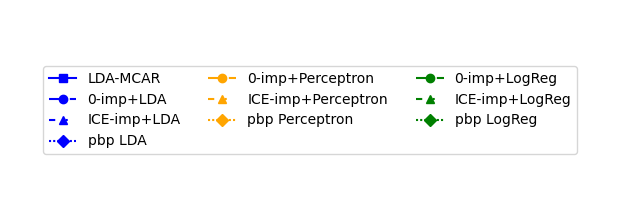

In [35]:
# Legend
plt.rcParams["pdf.fonttype"] = 42

# Data from your input
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}

markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}

dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.set_facecolor("white")  # Set white background
# ax.set_frame_on(False)  # Remove border

# Create dummy plots for legend
for model in palette.keys():
    plt.plot(
        [],
        [],
        label=model,
        color=palette[model],
        marker=markers[model],
        dashes=dashes[model],
    )

# Create legend without borders, centered, occupying full space
legend = plt.legend(
    loc="center",
    ncol=3,
    frameon=True,  # Remove box around legend
    bbox_to_anchor=(0.5, 0.5),  # Center in figure
)

# Remove everything else
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Ensure full figure usage

# Save without borders
plt.savefig(
    "legend_type1.pdf", bbox_inches="tight", facecolor="white", transparent=True
)

plt.show()

## Different sample size

In order to account for the different missingness mechanisms, misspecification robustness in generating $y$, and the effect of correlation between inputs, we study the following settings:

- LDA generated data with Toeplitz covariance and MCAR
- LDA generated data with isotropic covariance and MCAR
- LDA generated data with Toeplitz covariance and MNAR
- LDA generated data with isotropic covariance and MNAR
- Logistic generated data with isotropic covariance and MCAR
- Logistic generated data with Toeplitz covariance and MCAR
- Logistic generated data with isotropic covariance and MNAR
- Logistic generated data with Toeplitz covariance and MNAR


In [36]:
def df_test(
    regresseur, gen, lst_n=[], n_test=1000, repeat=3, title="", seed=0, b_risk=0
):
    """Tests multiple regressors on different datasets, measuring their performance across different training sizes.

        The function tests a list of regression models (`regresseur`) by training them on datasets of different sizes
        (`lst_n`), evaluating their test error on a held-out test set, and recording the training time. The results are
        saved to a CSV file and returned as a pandas DataFrame.

        Args:
            regresseur (list): A list of regression models (e.g., classifiers or regressors) to test.
            gen (function): A function that generates a dataset of the form (X, M, y), where X is the feature matrix,
                            M is the missingness matrix, and y is the target vector. This function should accept an
                            integer `n` (size of the dataset) and return the corresponding dataset.
            lst_n (list of int, optional): A list of integers specifying different training set sizes to test.
                                           Defaults to an empty list, which would result in no testing.
            n_test (int, optional): The size of the test set to use for evaluating performance. Defaults to 1000.
            repeat (int, optional): The number of times the test should be repeated. Defaults to 3.
            title (str, optional): A string to use as a prefix for the output CSV file's name. The result will be
                                   saved as `title<repeat>.csv`. Defaults to an empty string.
            seed (int, optional): The seed to use for random number generation. Defaults to 0.
            b_risk (float, optional): The Bayes risk value to subtract from the test error. This could represent a
                                      known or theoretical optimal value. Defaults to 0.

        Returns:
            pd.DataFrame: A pandas DataFrame containing the results of the tests. The DataFrame has the following columns:
                          - "n": The size of the training set used for the test.
                          - "err": The absolute error of the regressor's performance, calculated as the difference between
                                   the observed test error and the Bayes risk (`b_risk`).
                          - "Regressor": The name of the regressor being tested.
                          - "Time": The time taken to train and test the model.

    The function performs the following steps:
        1. Generates datasets using the `gen` function for the maximum training set size plus the test set size.
        2. Iterates through each regressor in the `regresseur` list and each training set size in `lst_n`.
        3. For each combination, it splits the dataset into a training and test set, fits the model, and measures its
           error and training time.
        4. Records the test error (adjusted by `b_risk`) and training time, and stores the results in a DataFrame.
        5. Saves the results to a CSV file with the name determined by the `title` and `repeat` parameters.
    """

    np.random.seed(seed)
    n_max = lst_n[-1]

    lst_toys = [gen(n_max + n_test) for j in range(repeat)]
    df_res = pd.DataFrame({"n": [], "err": [], "Regressor": [], "Time": []})
    for k in range(len(regresseur)):
        reg = regresseur[k]
        for n in lst_n:
            for X, M, y in lst_toys:
                # data generation, data split
                X_train, M_train, y_train = X[:n], M[:n], y[:n]
                X_test, M_test, y_test = X[n_max:], M[n_max:], y[n_max:]
                tic = time.perf_counter()
                reg.fit(X_train, M_train, y_train)
                toc = time.perf_counter()
                new_row = pd.DataFrame(
                    [
                        {
                            "n": n,
                            "err": np.abs(
                                reg.test_error(X_test, M_test, y_test) - b_risk
                            ),
                            "Regressor": reg.name,
                            "Time": toc - tic,
                        }
                    ]
                )
                df_res = pd.concat([df_res, new_row], ignore_index=True)
    df_res.to_csv(title + str(repeat) + ".csv")
    return df_res

### LDA generated data with Toeplitz covariance and MCAR

In [37]:
# Simulated dataset

d = 5
eta = 0.6
dist = 1.5
mu_0 = np.random.normal(loc=0, scale=5, size=(d))
mu_1 = mu_0 + np.random.choice([1, -1], size=d) * dist


def gen(n):
    return ToyDataset(
        n=n,
        d=d,
        correlation="cor2",
        eta=eta,
        mu_0=mu_0,
        mu_1=mu_1,
        missingness="MCAR",
        y_meth="LDA",
    )

Estimated Bayes risk without missing values 

In [38]:
# Bayes risk of complete data
def gen_comp(n):
    X, y = ToyDatasetComp(
        n=n,
        d=d,
        correlation="cor2",
        k=2,
        mu_0=mu_0,
        mu_1=mu_1,
        y_meth="LDA",
    )
    return X, y


n = 1000000
X, y = gen_comp(n)
X_train, y_train = X[:100000], y[:100000]
X_test, y_test = X[100000:], y[100000:]
grad_boost = GradientBoostingClassifier().fit(np.array(X_train, ndmin=2), y_train)
comp_bayes = np.mean(grad_boost.predict(X_test) != y_test)
comp_bayes

0.003678888888888889

Estimated Bayes risk with missing values 

In [39]:
X, M, y = gen(1000000)
X_train, M_train, y_train = X[:100000], M[:100000], y[:100000]
X_test, M_test, y_test = X[100000:], M[100000:], y[100000:]

reg = GradientBoostingPbP(name="GB-pbp")
reg.fit(X_train, M_train, y_train)
mis_bayes = reg.test_error(X_test, M_test, y_test)

In [40]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test(
    lst_reg,
    gen,
    lst_n=[40, 70, 150, 300, 500, 1000, 2500, 5000, 10000],
    n_test=10000,
    repeat=10,
    title="Toeplitz",
    seed=0,
    b_risk=0,
)

Bayes risk without missing data: 0.003678888888888889


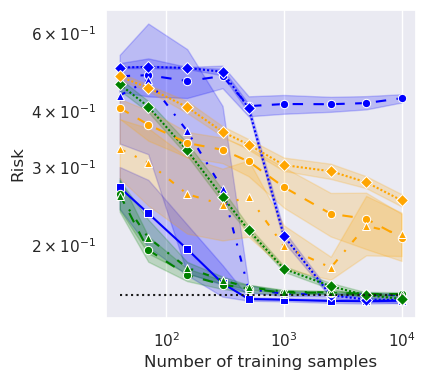

In [41]:
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="n",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()
lst_n = [40, 70, 150, 300, 500, 1000, 2500, 5000, 10000]
print("Bayes risk without missing data: " + str(comp_bayes))
plt.plot(lst_n, [(mis_bayes) for i in lst_n], "k:", label="Mis")

plt.xscale("log")
plt.yscale("log")


plt.ylabel("Risk")
plt.xlabel(r"Number of training samples")
plt.savefig("n-MCAR-cor2-LDA.pdf", bbox_inches="tight")
plt.show()

### LDA generated data with isotropic covariance and MCAR

In [42]:
d = 5
k = 2  # number of covariate by block
eta = 0.5
dist = 1.5
mu_0 = np.random.normal(loc=0, scale=5, size=(d))
mu_1 = mu_0 + np.random.choice([1, -1], size=d) * dist


def gen(n):
    return ToyDataset(
        n=n,
        d=d,
        correlation="iso",
        eta=eta,
        k=2,
        mu_0=mu_0,
        mu_1=mu_1,
        missingness="MCAR",
        y_meth="LDA",
        beta_logist=None,
        beta_self_mask=[-1, 1],
    )

In [43]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test(
    lst_reg,
    gen,
    lst_n=[40, 70, 150, 300, 500, 1000, 2500, 5000, 10000],
    n_test=1000,
    repeat=10,
    title="Isotropic",
    seed=0,
    b_risk=0,
)

Bayes risk without missing data: 0.046766256344546585


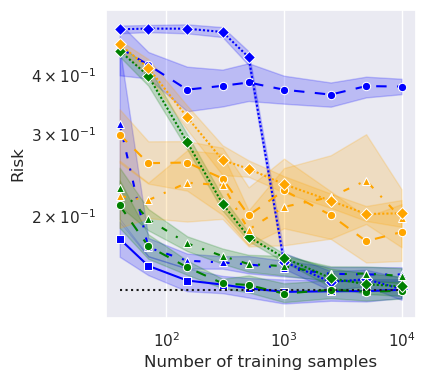

In [44]:
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="n",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()
lst_n = [40, 70, 150, 300, 500, 1000, 2500, 5000, 10000]
comp_bayes = stats.norm.cdf(-0.5 * np.linalg.norm(mu_1 - mu_0))
print("Bayes risk without missing data: " + str(comp_bayes))
combinations = list(itertools.product([0, 1], repeat=d))
combinations_array = np.array(combinations)
mis_bayes = 0
for m in combinations_array:
    if np.product(m) == 1:
        mis_bayes += 1 / 2 * eta**d
    else:
        mis_bayes += (
            stats.norm.cdf(-0.5 * dist * np.sqrt(np.sum(1 - m)))
            * (eta ** (sum(m)))
            * ((1 - eta) ** (d - sum(m)))
        )
plt.plot(lst_n, [(mis_bayes) for i in lst_n], "k:", label="Mis")


plt.xscale("log")
plt.yscale("log")


plt.ylabel("Risk")
plt.xlabel(r"Number of training samples")
plt.savefig("n-MCAR-iso-LDA.pdf", bbox_inches="tight")
plt.show()

### LDA generated data with Toeplitz covariance and MNAR

In [45]:
d = 5
k = 2  # number of covariate by block
eta = 0.5
dist = 2
mu_0 = np.random.normal(loc=0, scale=5, size=(d))
mu_1 = mu_0 + np.random.choice([1, -1], size=d) * dist


def gen(n):
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="cor2",
        eta=eta,
        k=2,
        mu_0=mu_0,
        mu_1=mu_1,
        missingness="MNAR",
        y_meth="LDA",
        beta_logist=None,
        beta_self_mask=[0, 1],
    )
    print("Proportion of missing values: " + str(np.sum(M == 1) / (n * d)))
    print("Proportion of y=0: " + str(sum(y == 0) / len(y)))
    return X, M, y

In [46]:
# Bayes risk of complete data
def gen_comp(n):
    X, y = ToyDatasetComp(
        n=n,
        d=d,
        correlation="cor2",
        k=2,
        mu_0=mu_0,
        mu_1=mu_1,
        y_meth="LDA",
        beta_logist=None,
    )
    return X, y


n = 1000000
X, y = gen_comp(n)
X_train, y_train = X[:100000], y[:100000]
X_test, y_test = X[100000:], y[100000:]
grad_boost = GradientBoostingClassifier().fit(np.array(X_train, ndmin=2), y_train)
comp_bayes = np.mean(grad_boost.predict(X_test) != y_test)
comp_bayes

0.00018333333333333334

In [47]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test(
    lst_reg,
    gen,
    lst_n=[40, 70, 150, 300, 500, 1000, 2500, 5000, 10000, 20000],
    n_test=10000,
    repeat=10,
    title="Toep-MNAR",
    seed=0,
    b_risk=0,
)

Proportion of missing values: 0.6012133333333334
Proportion of y=0: 0.4987666666666667
Proportion of missing values: 0.5992933333333333
Proportion of y=0: 0.49793333333333334
Proportion of missing values: 0.6009133333333333
Proportion of y=0: 0.5002666666666666
Proportion of missing values: 0.6013066666666667
Proportion of y=0: 0.5048333333333334
Proportion of missing values: 0.6009533333333333
Proportion of y=0: 0.4979
Proportion of missing values: 0.60158
Proportion of y=0: 0.5023
Proportion of missing values: 0.6005933333333333
Proportion of y=0: 0.49743333333333334
Proportion of missing values: 0.6003533333333333
Proportion of y=0: 0.49756666666666666
Proportion of missing values: 0.6024933333333333
Proportion of y=0: 0.5026
Proportion of missing values: 0.5993933333333333
Proportion of y=0: 0.4967666666666667


Estimated Bayes risk with missing values

In [48]:
X, M, y = gen(1000000)
X_train, M_train, y_train = X[:100000], M[:100000], y[:100000]
X_test, M_test, y_test = X[100000:], M[100000:], y[100000:]

reg = GradientBoostingPbP(name="GB-pbp")
reg.fit(X_train, M_train, y_train)
mis_bayes = reg.test_error(X_test, M_test, y_test)

Proportion of missing values: 0.6007536
Proportion of y=0: 0.500412


Bayes risk without missing data: 0.00013628993485513972


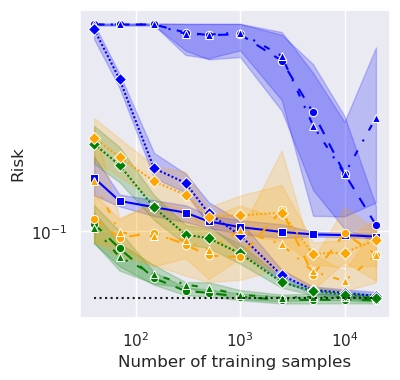

In [49]:
# Learning curves : Risk
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}  # (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="n",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()
comp_bayes = stats.norm.cdf(
    -0.5 * np.linalg.norm((fractional_matrix_power(toep(d), -0.5)) @ (mu_1 - mu_0))
)
print("Bayes risk without missing data: " + str(comp_bayes))

lst_n = [40, 70, 150, 300, 500, 1000, 2500, 5000, 10000, 20000]
plt.plot(lst_n, [(mis_bayes) for i in lst_n], "k:", label="Mis")

plt.xscale("log")
plt.yscale("log")


plt.ylabel("Risk")
plt.xlabel(r"Number of training samples")
plt.savefig("n-MNAR-cor2-LDA.pdf", bbox_inches="tight")
plt.show()

### LDA generated data with isotropic covariance and MNAR

In [50]:
d = 5
k = 2  # number of covariate by block
eta = 0.5
dist = 2
mu_0 = np.random.normal(loc=0, scale=5, size=(d))
mu_1 = mu_0 + np.random.choice([1, -1], size=d) * dist


def gen(n):
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="iso",
        eta=eta,
        k=2,
        mu_0=mu_0,
        mu_1=mu_1,
        missingness="MNAR",
        y_meth="LDA",
        beta_logist=None,
        beta_self_mask=[0, 1],
    )
    print("Proportion of missing values: " + str(np.sum(M == 1) / (n * d)))
    return X, M, y

In [51]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test(
    lst_reg,
    gen,
    lst_n=[40, 70, 150, 300, 500, 1000, 2500, 5000, 10000],
    n_test=1000,
    repeat=10,
    title="Iso-MNAR",
    seed=0,
    b_risk=0,
)
#

Proportion of missing values: 0.6763636363636364
Proportion of missing values: 0.6780545454545455
Proportion of missing values: 0.6784181818181818
Proportion of missing values: 0.6752545454545454
Proportion of missing values: 0.6758
Proportion of missing values: 0.6763454545454546
Proportion of missing values: 0.677
Proportion of missing values: 0.6785636363636364
Proportion of missing values: 0.6775454545454546
Proportion of missing values: 0.6785272727272728


In [52]:
n = 1000000
(X, M, y) = gen(n)
combinations = list(itertools.product([0, 1], repeat=d))
combinations_array = np.array(combinations)
mis_bayes = 0
pm = {}
for m in combinations_array:
    eq = np.all(M == m, axis=1)
    pm[str(m)] = np.sum(eq) / n

Proportion of missing values: 0.677111


Bayes risk without missing data: 0.012673659338734126


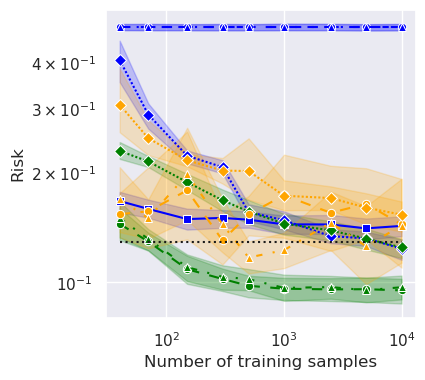

In [53]:
# Learning curves : Risk
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="n",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()
lst_n = [40, 70, 150, 300, 500, 1000, 2500, 5000, 10000]
comp_bayes = stats.norm.cdf(-0.5 * np.linalg.norm(mu_1 - mu_0))
print("Bayes risk without missing data: " + str(comp_bayes))
combinations = list(itertools.product([0, 1], repeat=d))
combinations_array = np.array(combinations)
mis_bayes = 0
for m in combinations_array:
    if np.product(m) == 1:
        mis_bayes += 1 / 2 * pm[str(m)]
    else:
        mis_bayes += stats.norm.cdf(-0.5 * dist * np.sqrt(np.sum(1 - m))) * pm[str(m)]
plt.plot(lst_n, [(mis_bayes) for i in lst_n], "k:", label="Mis")


plt.xscale("log")
plt.yscale("log")


plt.ylabel("Risk")
plt.xlabel(r"Number of training samples")
plt.savefig("n-MNAR-iso-LDA.pdf", bbox_inches="tight")
plt.show()

### Logistic generated data with isotropic covariance and MCAR

In [54]:
d = 5
eta = 0.5
beta_logist = np.random.normal(size=d)


def gen(n):
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="iso",
        eta=eta,
        missingness="MCAR",
        y_meth="logist",
        beta_logist=beta_logist,
        beta_self_mask=[0, 1],
    )
    print("Proportion of missing values: " + str(np.sum(M == 1) / (n * d)))
    return X, M, y

In [55]:
# Bayes risk of complete data
def gen_comp(n):
    X, y = ToyDatasetComp(
        n=n,
        d=d,
        correlation="iso",
        mu_0=None,
        mu_1=None,
        y_meth="logist",
        beta_logist=beta_logist,
    )
    return X, y


n = 100000
X, y = gen_comp(n)
comp_bayes = np.mean(np.minimum(sigma(X @ beta_logist), 1 - sigma(X @ beta_logist)))
comp_bayes

0.3125458872304486

In [56]:
X, M, y = gen(1000000)
X_train, M_train, y_train = X[:100000], M[:100000], y[:100000]
X_test, M_test, y_test = X[100000:], M[100000:], y[100000:]

reg = GradientBoostingPbP(name="GB-pbp")
reg.fit(X_train, M_train, y_train)
mis_bayes = reg.test_error(X_test, M_test, y_test)

Proportion of missing values: 0.4999756


In [57]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test(
    lst_reg,
    gen,
    lst_n=[40, 70, 150, 300, 500, 1000, 2500, 5000, 10000],
    n_test=1000,
    repeat=10,
    title="Iso-MCAR",
    seed=0,
    b_risk=0,
)
#

Proportion of missing values: 0.5040181818181818
Proportion of missing values: 0.4974545454545454
Proportion of missing values: 0.4999090909090909
Proportion of missing values: 0.5017454545454545
Proportion of missing values: 0.5035454545454545
Proportion of missing values: 0.5005636363636363
Proportion of missing values: 0.5004181818181819
Proportion of missing values: 0.5010909090909091
Proportion of missing values: 0.4984363636363636
Proportion of missing values: 0.49614545454545456


Bayes risk without missing data: 0.3125458872304486


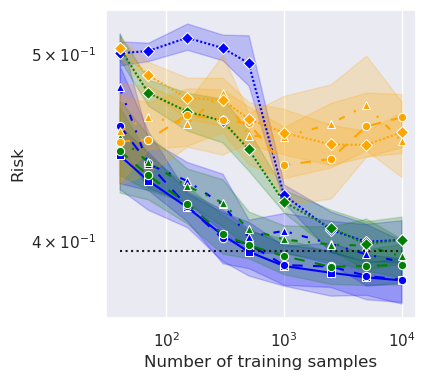

In [58]:
# Learning curves : Risk
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}  # (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="n",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()
lst_n = [40, 70, 150, 300, 500, 1000, 2500, 5000, 10000]
print("Bayes risk without missing data: " + str(comp_bayes))
plt.plot(lst_n, [(mis_bayes) for i in lst_n], "k:", label="Mis")

plt.xscale("log")
plt.yscale("log")


plt.ylabel("Risk")
plt.xlabel(r"Number of training samples")
plt.savefig("n-MCAR-iso-Logist.pdf", bbox_inches="tight")
plt.show()

### Logistic generated data with Toeplitz covariance and MCAR

In [59]:
d = 5
k = 2  # number of covariate by block
eta = 0.5
beta_logist = np.random.normal(size=d)


def gen(n):
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="cor2",
        eta=eta,
        k=2,
        mu_0=None,
        mu_1=None,
        missingness="MCAR",
        y_meth="logist",
        beta_logist=beta_logist,
        beta_self_mask=[0, 1],
    )
    print("Proportion of missing values: " + str(np.sum(M == 1) / (n * d)))
    return X, M, y

In [60]:
# Bayes risk of complete data
def gen_comp(n):
    X, y = ToyDatasetComp(
        n=n,
        d=d,
        correlation="cor2",
        k=2,
        mu_0=None,
        mu_1=None,
        y_meth="logist",
        beta_logist=beta_logist,
    )
    return X, y


n = 1000000
X, y = gen_comp(n)
X_train, y_train = X[:100000], y[:100000]
X_test, y_test = X[100000:], y[100000:]
grad_boost = GradientBoostingClassifier().fit(np.array(X_train, ndmin=2), y_train)
comp_bayes = np.mean(grad_boost.predict(X_test) != y_test)
comp_bayes

0.3105611111111111

In [61]:
X, M, y = gen(1000000)
X_train, M_train, y_train = X[:100000], M[:100000], y[:100000]
X_test, M_test, y_test = X[100000:], M[100000:], y[100000:]

reg = GradientBoostingPbP(name="GB-pbp")
reg.fit(X_train, M_train, y_train)
mis_bayes = reg.test_error(X_test, M_test, y_test)

Proportion of missing values: 0.4997116


In [62]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test(
    lst_reg,
    gen,
    lst_n=[40, 70, 150, 300, 500, 1000, 2500, 5000, 10000],
    n_test=10000,
    repeat=10,
    title="Cor2-MCAR",
    seed=0,
    b_risk=0,
)

Proportion of missing values: 0.50237
Proportion of missing values: 0.50242
Proportion of missing values: 0.50115
Proportion of missing values: 0.50104
Proportion of missing values: 0.4995
Proportion of missing values: 0.50057
Proportion of missing values: 0.49807
Proportion of missing values: 0.50152
Proportion of missing values: 0.49919
Proportion of missing values: 0.50087


Bayes risk without missing data: 0.3105611111111111


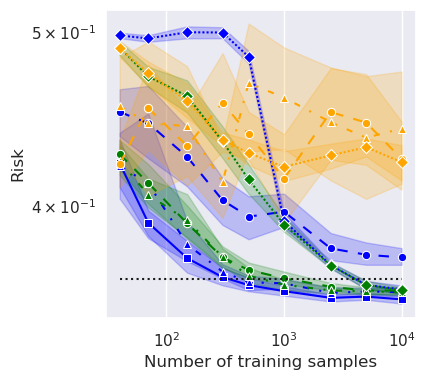

In [63]:
# Learning curves : Risk
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}  # (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="n",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()
lst_n = [40, 70, 150, 300, 500, 1000, 2500, 5000, 10000]
print("Bayes risk without missing data: " + str(comp_bayes))
plt.plot(lst_n, [(mis_bayes) for i in lst_n], "k:", label="Mis")


plt.xscale("log")
plt.yscale("log")


plt.ylabel("Risk")
plt.xlabel(r"Number of training samples")
plt.savefig("n-MCAR-cor2-Logist.pdf", bbox_inches="tight")
plt.show()

### Logistic generated data with isotropic covariance and MNAR

In [64]:
d = 5
k = 2  # number of covariate by block
eta = 0.5
beta_logist = np.random.normal(size=d)


def gen(n):
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="iso",
        eta=eta,
        k=2,
        mu_0=None,
        mu_1=None,
        missingness="MNAR",
        y_meth="logist",
        beta_logist=beta_logist,
        beta_self_mask=[0, 1],
    )
    print("Proportion of missing values: " + str(np.sum(M == 1) / (n * d)))
    return X, M, y

In [65]:
# Bayes risk of complete data
def gen_comp(n):
    X, y = ToyDatasetComp(
        n=n,
        d=d,
        correlation="iso",
        eta=eta,
        mu_0=None,
        mu_1=None,
        y_meth="logist",
        beta_logist=beta_logist,
    )
    return X, y


n = 100000
X, y = gen_comp(n)
comp_bayes = np.mean(np.minimum(sigma(X @ beta_logist), 1 - sigma(X @ beta_logist)))
comp_bayes

0.24364744504320487

In [66]:
X, M, y = gen(1000000)
X_train, M_train, y_train = X[:100000], M[:100000], y[:100000]
X_test, M_test, y_test = X[100000:], M[100000:], y[100000:]

reg = GradientBoostingPbP(name="GB-pbp")
reg.fit(X_train, M_train, y_train)
mis_bayes = reg.test_error(X_test, M_test, y_test)

Proportion of missing values: 0.500313


In [67]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test(
    lst_reg,
    gen,
    lst_n=[40, 70, 150, 300, 500, 1000, 2500, 5000, 10000],
    n_test=1000,
    repeat=10,
    title="Iso-MNAR",
    seed=0,
    b_risk=0,
)
#

Proportion of missing values: 0.5027636363636364
Proportion of missing values: 0.5025090909090909
Proportion of missing values: 0.4969636363636364
Proportion of missing values: 0.5027090909090909
Proportion of missing values: 0.49936363636363634
Proportion of missing values: 0.5002909090909091
Proportion of missing values: 0.49814545454545456
Proportion of missing values: 0.5013454545454545
Proportion of missing values: 0.5019272727272728
Proportion of missing values: 0.4989636363636364


Bayes risk without missing data: 0.24364744504320487


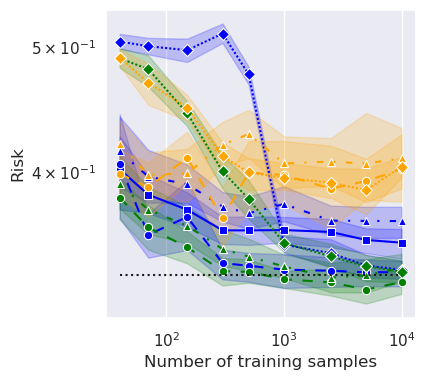

In [68]:
# Learning curves : Risk
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}  # (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="n",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()
lst_n = [40, 70, 150, 300, 500, 1000, 2500, 5000, 10000]
print("Bayes risk without missing data: " + str(comp_bayes))
plt.plot(lst_n, [(mis_bayes) for i in lst_n], "k:", label="Mis")


plt.xscale("log")
plt.yscale("log")


plt.ylabel("Risk")
plt.xlabel(r"Number of training samples")
plt.savefig("n-MNAR-iso-Logist.pdf", bbox_inches="tight")
plt.show()

### Logistic generated data with Toeplitz covariance and MNAR

In [69]:
d = 5
k = 2  # number of covariate by block
eta = 0.5
beta_logist = np.random.normal(size=d)


def gen(n):
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="cor2",
        eta=eta,
        k=2,
        mu_0=None,
        mu_1=None,
        missingness="MNAR",
        y_meth="logist",
        beta_logist=beta_logist,
        beta_self_mask=[0, 1],
    )
    print("Proportion of missing values: " + str(np.sum(M == 1) / (n * d)))
    return X, M, y

In [70]:
# Bayes risk of complete data
def gen_comp(n):
    X, y = ToyDatasetComp(
        n=n,
        d=d,
        correlation="cor2",
        eta=eta,
        mu_0=None,
        mu_1=None,
        y_meth="logist",
        beta_logist=beta_logist,
    )
    return X, y


n = 1000000
X, y = gen_comp(n)
X_train, y_train = X[:100000], y[:100000]
X_test, y_test = X[100000:], y[100000:]
grad_boost = GradientBoostingClassifier().fit(np.array(X_train, ndmin=2), y_train)
comp_bayes = np.mean(grad_boost.predict(X_test) != y_test)
comp_bayes

0.18045666666666665

In [71]:
X, M, y = gen(1000000)
X_train, M_train, y_train = X[:100000], M[:100000], y[:100000]
X_test, M_test, y_test = X[100000:], M[100000:], y[100000:]

reg = GradientBoostingPbP(name="GB-pbp")
reg.fit(X_train, M_train, y_train)
mis_bayes = reg.test_error(X_test, M_test, y_test)

Proportion of missing values: 0.4998654


In [72]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test(
    lst_reg,
    gen,
    lst_n=[40, 70, 150, 300, 500, 1000, 2500, 5000, 10000],
    n_test=10000,
    repeat=10,
    title="Toep-MNAR",
    seed=0,
    b_risk=0,
)
#

Proportion of missing values: 0.49948
Proportion of missing values: 0.49749
Proportion of missing values: 0.4973
Proportion of missing values: 0.50229
Proportion of missing values: 0.498
Proportion of missing values: 0.50003
Proportion of missing values: 0.49866
Proportion of missing values: 0.50031
Proportion of missing values: 0.49849
Proportion of missing values: 0.49658


Bayes risk without missing data: 0.18045666666666665


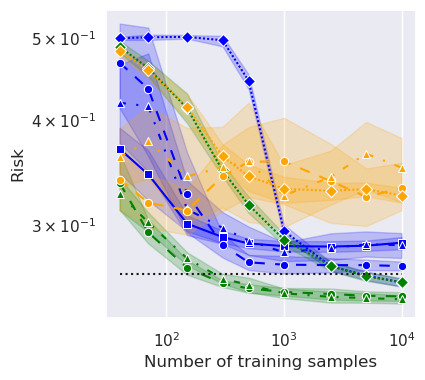

In [73]:
# Learning curves : Risk
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}  # (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="n",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()
lst_n = [40, 70, 150, 300, 500, 1000, 2500, 5000, 10000]
print("Bayes risk without missing data: " + str(comp_bayes))
plt.plot(lst_n, [(mis_bayes) for i in lst_n], "k:", label="Mis")

plt.xscale("log")
plt.yscale("log")


plt.ylabel("Risk")
plt.xlabel(r"Number of training samples")
plt.savefig("n-MNAR-cor2-Logist.pdf", bbox_inches="tight")
plt.show()

## Different distances

In this section, we study the effect of the signal-to-noise ratio by varying the distance between the centers of both classes. 

Setting: LDA generated data with isotropic covariance and MCAR


In [74]:
def df_test_dist(
    regresseur, gen_d, lst_dist=[], n_train=50, repeat=3, title="", seed=0, b_risk=0
):
    """
    Tests multiple regressors on datasets generated from different distances between the classes.

    This function evaluates the performance of regression models (`regresseur`) by training them on datasets
    sampled from different distances (`lst_dist`). Each regressor is trained on `n_train` samples and tested
    on the remaining data. The results, including test errors and training times, are saved to a CSV file
    and returned as a pandas DataFrame.

    Args:
        regresseur (list): A list of regression models (e.g., classifiers or regressors) to test.
        gen_d (function): A function that generates datasets given a distance parameter from `lst_dist`.
                          The function should accept a single parameter (distribution type) and return a tuple
                          (X, M, y), where:
                          - X: Feature matrix.
                          - M: Missingness matrix.
                          - y: Target vector.
        lst_dist (list, optional): A list of different distances parameters to generate datasets.
                                   Defaults to an empty list, meaning no testing will be performed.
        n_train (int, optional): The number of training samples to use. The remaining samples are used for testing.
                                 Defaults to 50.
        repeat (int, optional): The number of times the test should be repeated for statistical reliability.
                                Defaults to 3.
        title (str, optional): A string prefix for the output CSV file name. The results are saved as
                               `"dist" + title + str(repeat) + ".csv"`. Defaults to an empty string.
        seed (int, optional): The random seed for reproducibility. Defaults to 0.
        b_risk (float, optional): The Bayes risk value to subtract from the test error, used for performance
                                  evaluation. Defaults to 0.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the test results with the following columns:
                      - "dist": The distance parameter used for dataset generation.
                      - "err": The absolute test error, calculated as the difference between the observed
                               test error and the Bayes risk (`b_risk`).
                      - "Regressor": The name of the regressor being tested.
                      - "Time": The time taken to train and evaluate the model.

    Steps:
    1. Generates datasets using `gen_d` for each distance in `lst_dist`, repeating the process `repeat` times.
    2. Iterates through each regressor in `regresseur` and each dataset generated from `lst_dist`.
    3. Splits each dataset into a training set (`n_train` samples) and a test set (remaining samples).
    4. Trains each regressor on the training data and evaluates its performance on the test data.
    5. Records the test error (adjusted with `b_risk`) and training time.
    6. Saves the results to a CSV file named `"dist" + title + str(repeat) + ".csv"`.

    """

    np.random.seed(seed)

    lst_toys = [[gen_d(dist) for dist in lst_dist] for j in range(repeat)]
    df_res = pd.DataFrame({"dist": [], "err": [], "Regressor": [], "Time": []})
    for k in range(len(regresseur)):
        reg = regresseur[k]
        for i in range(len(lst_dist)):
            for toys in lst_toys:
                # data generation, data split
                (X, M, y) = toys[i]
                X_train, M_train, y_train = X[:n_train], M[:n_train], y[:n_train]
                X_test, M_test, y_test = X[n_train:], M[n_train:], y[n_train:]
                d = X_train.shape[1]
                tic = time.perf_counter()
                reg.fit(X_train, M_train, y_train)
                toc = time.perf_counter()

                new_row = pd.DataFrame(
                    [
                        {
                            "dist": lst_dist[i],
                            "err": np.abs(
                                reg.test_error(X_test, M_test, y_test) - b_risk
                            ),
                            "Regressor": reg.name,
                            "Time": toc - tic,
                        }
                    ]
                )
                df_res = pd.concat([df_res, new_row], ignore_index=True)
    df_res.to_csv("dist" + title + str(repeat) + ".csv")
    return df_res

In [75]:
# Simulated dataset
ntrain = 750
ntest = 1000
n = ntrain + ntest
d = 5
eta = 0.5


def gen_d(dist):
    mu_0 = np.random.normal(loc=0, scale=5, size=(d))
    mu_1 = mu_0 + np.random.choice([1, -1], size=d) * dist
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="iso",
        eta=eta,
        mu_0=mu_0,
        mu_1=mu_1,
        missingness="MCAR",
        y_meth="LDA",
    )
    return X, M, y

In [76]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]

df = df_test_dist(
    lst_reg,
    gen_d,
    lst_dist=[10, 3, 2, 1.5, 1, 0.5],
    n_train=ntrain,
    repeat=10,
    title="Isotropic",
    seed=0,
)

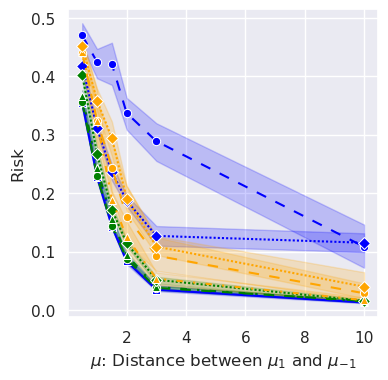

In [77]:
# Learning curves : Risk
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="dist",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()


plt.ylabel("Risk")
plt.xlabel(r"$\mu$: Distance between $\mu_1$ and $\mu_{-1}$")
plt.savefig("dist-MCAR-iso.pdf", bbox_inches="tight")
plt.show()

With less sample size

In [78]:
# Simulated dataset
ntrain = 50
ntest = 1000
n = ntrain + ntest
d = 5
k = 2  # number of covariate by block
eta = 0.5


def gen_d(dist):
    mu_0 = np.random.normal(loc=0, scale=5, size=(d))
    mu_1 = mu_0 + np.random.choice([1, -1], size=d) * dist
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="iso",
        eta=eta,
        k=2,
        mu_0=mu_0,
        mu_1=mu_1,
        missingness="MCAR",
        y_meth="LDA",
        beta_logist=None,
        beta_self_mask=[0, 1],
    )
    return X, M, y

In [79]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]

df = df_test_dist(
    lst_reg,
    gen_d,
    lst_dist=[3, 2, 1.5, 1, 0.5],
    n_train=ntrain,
    repeat=10,
    title="Isotropic",
    seed=0,
    b_risk=0,
)

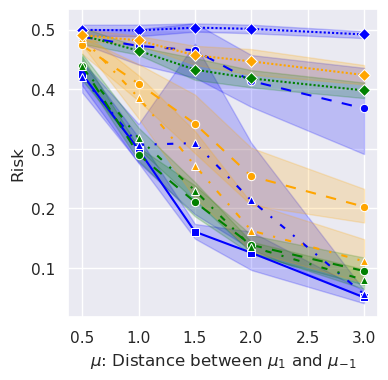

In [80]:
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="dist",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()


plt.ylabel("Risk")
plt.xlabel(r"$\mu$: Distance between $\mu_1$ and $\mu_{-1}$")
plt.savefig("dist-MCAR-iso-n-small.pdf", bbox_inches="tight")
plt.show()

## Missingness

We study different missingness probabilities.

Setting: LDA generated data with isotropic covariance and MCAR


In [81]:
# Simulated dataset
ntrain = 50
ntest = 1000
n = ntrain + ntest
d = 5
dist = 1.5


def gen_eta(eta):
    mu_0 = np.random.normal(loc=0, scale=5, size=(d))
    mu_1 = mu_0 + np.random.choice([1, -1], size=d) * dist
    X, M, y = ToyDataset(
        n=n,
        d=d,
        correlation="iso",
        eta=eta,
        mu_0=mu_0,
        mu_1=mu_1,
        missingness="MCAR",
        y_meth="LDA",
    )
    return X, M, y

In [82]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]

df = df_test_dist(
    lst_reg,
    gen_eta,
    lst_dist=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    n_train=ntrain,
    repeat=10,
    title="Isotropic",
    seed=0,
    b_risk=0,
)

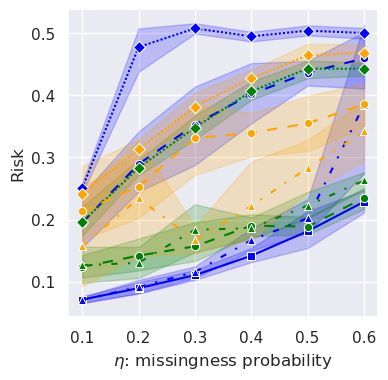

In [83]:
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="dist",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()


plt.ylabel("Risk")
plt.xlabel(r"$\eta$: missingness probability")
plt.savefig("missingness-MCAR-iso.pdf", bbox_inches="tight")
plt.show()

## Dimension

We study the effect of the dimensionality.

Setting: LDA generated data with isotropic covariance and MCAR


In [84]:
# Simulated dataset
ntrain = 50
ntest = 1000
n = ntrain + ntest
dist = 1.5
eta = 0.5


def gen_dim(dim):
    mu_0 = np.random.normal(loc=0, scale=5, size=(dim))
    mu_1 = mu_0 + np.random.choice([1, -1], size=dim) * dist
    X, M, y = ToyDataset(
        n=n,
        d=dim,
        correlation="iso",
        eta=eta,
        mu_0=mu_0,
        mu_1=mu_1,
        missingness="MCAR",
        y_meth="LDA",
    )
    return X, M, y

In [85]:
lst_reg = [
    LDA_MCAR(name="LDA-MCAR"),
    LDA0Imputation(name="0-imp+LDA"),
    LDAIterativeImputation(name="ICE-imp+LDA"),
    LDAPbP(name="pbp LDA"),
    LogisticRegression0Imputation(name="0-imp+LogReg"),
    LogisticRegressionIterativeImputation(name="ICE-imp+LogReg"),
    LogisticRegressionPbP(name="pbp LogReg"),
    Perceptron0Imputation(name="0-imp+Perceptron"),
    PerceptronIterativeImputation(name="ICE-imp+Perceptron"),
    PerceptronPbP(name="pbp Perceptron"),
]
df = df_test_dist(
    lst_reg,
    gen_dim,
    lst_dist=[2, 4, 5, 8, 10, 15, 30],
    n_train=ntrain,
    repeat=10,
    title="Isotropic",
    seed=0,
    b_risk=0,
)

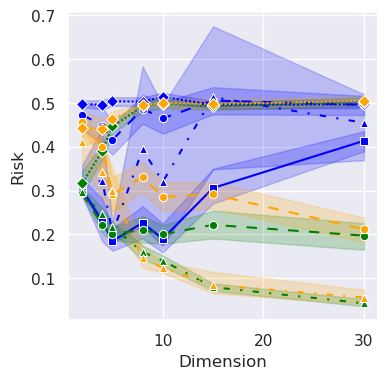

In [86]:
palette = {
    "LDA-MCAR": "blue",
    "0-imp+LDA": "blue",
    "ICE-imp+LDA": "blue",
    "pbp LDA": "blue",
    "0-imp+Perceptron": "orange",
    "ICE-imp+Perceptron": "orange",
    "pbp Perceptron": "orange",
    "0-imp+LogReg": "green",
    "ICE-imp+LogReg": "green",
    "pbp LogReg": "green",
}
markers = {
    "LDA-MCAR": "s",
    "0-imp+LDA": "o",
    "ICE-imp+LDA": "^",
    "pbp LDA": "D",
    "0-imp+Perceptron": "o",
    "ICE-imp+Perceptron": "^",
    "pbp Perceptron": "D",
    "0-imp+LogReg": "o",
    "ICE-imp+LogReg": "^",
    "pbp LogReg": "D",
}
dashes = {
    "LDA-MCAR": (),
    "0-imp+LDA": (5, 5),
    "ICE-imp+LDA": (3, 5, 1, 5),
    "pbp LDA": (1, 1),
    "0-imp+Perceptron": (5, 5),
    "ICE-imp+Perceptron": (3, 5, 1, 5),
    "pbp Perceptron": (1, 1),
    "0-imp+LogReg": (5, 5),
    "ICE-imp+LogReg": (3, 5, 1, 5),
    "pbp LogReg": (1, 1),
}

sns.set(rc={"figure.figsize": (4, 4)})
sns.lineplot(
    data=df,
    x="dist",
    y="err",
    hue="Regressor",
    palette=palette,
    style="Regressor",
    markers=markers,
    dashes=dashes,
).get_legend().remove()


plt.ylabel("Risk")
plt.xlabel(r"Dimension")
plt.savefig("dim-MCAR-iso.pdf", bbox_inches="tight")
plt.show()